#### Downloads GOES-16 ABI L1b images from the 'noaa-goes-16' Amazon S3 bucket for the selected date, product,  band, and start/end times. Using the latitude and longitude of the Atmospheric Radiation Measurement (ARM) Southern Great Plains (SGP) Central Facility, the satellite images are cropped and saved as a new image of n x n pixels surrounding the site.

In [1]:
import numpy as np
import s3fs
import datetime
import os
import netCDF4
import xarray as xr
import cartopy, cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
# Find Julian day from given year/month/day

def julian(year_name, month_name, day_name):
    
    calendar = datetime.datetime(year_name, month_name, day_name)
    julian_day = calendar.strftime('%j')
    
    return julian_day

In [3]:
# Create list of ABI data file names for given satellite/product and date/time period

def aws_list(year_name, month_name, day_name, starthour, startmin, endhour, endmin, satellite_name, view_name, sat_band, product):
    
    # Access AWS using anonymous credentials
    aws = s3fs.S3FileSystem(anon=True)
    
    # Make a list of all data files for the selected date and start/end times
    julian_day = julian(year_name, month_name, day_name)
    hour_range = range(int(starthour), int(endhour) + 1)
    all_hours_list = []
    for i in hour_range:
        hour_files = aws.ls('noaa-goes' + str(satellite_name) + '/' + product + '/' + str(year_name) + '/' + julian_day + '/' + str(i) + '/', refresh=True)
        all_hours_list.extend(hour_files)
    
    # Extract and return a list of data files for the desired period and band
    data = []
    
    # List file names
    for i in all_hours_list:
        if view_name == 'CONUS': 

            # Select only the files that are between the desired start and end time
            if i[-42:-38] >= (starthour + startmin) and i[-26:-22] <= (endhour + endmin):  

                # Account for the change in default scan mode of the ABI
                if i[-60:-57] == 'M3C' or i[-60:-57] == 'M6C':
                    
                    # Get desired band/channel
                    if i[-57:-55]  == sat_band:
                        data.append(i)
        else:
            continue

    return data

In [4]:
def proj(ds):
    
    # Transform the image coordinates to latitiude and longitude 
    # This is needed to extract arrays of pixels around the SGP site
    
    # Get the information needed for the projection
    p = ds['goes_imager_projection']

    # Projection x, y coordinates--> scanning angle (radians) * sat height
    x = ds['x'][:] * p.perspective_point_height
    y = ds['y'][:] * p.perspective_point_height
    
    # Create geostationary projection map object
    globe = ccrs.Globe(semimajor_axis=p.semi_major_axis,
                            semiminor_axis=p.semi_minor_axis,
                            inverse_flattening=p.inverse_flattening)
    geos = ccrs.Geostationary(central_longitude=p.longitude_of_projection_origin, 
                            satellite_height=p.perspective_point_height,
                            sweep_axis=p.sweep_angle_axis,
                            globe=globe)
    
    # Transform current image projection coordinates (x,y) to lat, lon values
    X, Y = np.meshgrid(x,y)
    a = ccrs.PlateCarree().transform_points(geos, X, Y)
    lons, lats = a[:,:,0], a[:,:,1]

    # Create an xarray dataset with the lats, lons
    latlon = xr.Dataset(dict(latitude=(('y', 'x'), lats), 
                         longitude=(('y', 'x'), lons)))
    latlon.latitude.attrs = dict(standard_name='latitude', long_name='latitude', units='degrees_north')
    latlon.longitude.attrs = dict(standard_name='longitude', long_name='longitude', units='degrees_east')
    latlon.coords['latitude'] = latlon.latitude
    latlon.coords['longitude'] = latlon.longitude
    
    # Merge the two datasets
    ds2 = xr.merge([ds, latlon])

    return ds2

In [5]:
def locate_index(ds_latlon):
    
    # Locate the index of the satellite pixel closest to the ARM SGP central facility
    # Based on: https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/Nearest_lat-lon_Grid.ipynb
    
    # Latitude and longitude of the ARM SGP central facility
    sgp_lon = -97.487643
    sgp_lat = 36.607322
    
    # Calc the absolute value of the difference between the SGP lat/lon and every grid point
    abslat = np.abs(ds_latlon.latitude.values-sgp_lat)
    abslon= np.abs(ds_latlon.longitude.values-sgp_lon)
    
    # Combine abslon & abslat to find the local max difference
    c = np.maximum(abslon, abslat)
    
    # Find the pixel where the absolute difference is minimum; this is pixel closest to SGP site
    r = np.argwhere(c==c.min())
    
    # Get the index (x,y) of the closest pixel
    y, x = np.where(c == np.min(c)) 

    # Grab the radiance, latitude, and longitude at that pixel
    grid_data = ds_latlon.Rad[y[0], x[0]] 
    grid_lat = ds_latlon.latitude[y[0], x[0]] 
    grid_lon = ds_latlon.longitude[y[0], x[0]] 

    #print("Value of %s at %s , %s" % (grid_data.values, grid_lat.values, grid_lon.values)) 
    #print("%s %s is the nearest grid to %s %s" % (grid_lat.values, grid_lon.values, sgp_lat, sgp_lon))
    
    return y, x

In [6]:
def extract_array(ds, y, x, band):
    
    # Extract an n x n array of pixels around SGP site
    n = 80
    xs = np.arange(x - n, x + n, 1)
    ys = np.arange(y - n, y + n, 1)
    
    # Create an xarray dataframe for the extracted array (essentially cropping the image)
    ds2 = ds.isel(y = ys, x = xs)
    
    #'t' variable is the scan's midpoint time
    midpoint = str(ds2['t'].data)[:-8]
    scan_mid = datetime.datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')
    scan_mid2 = datetime.datetime.strftime(scan_mid, '%Y-%m-%dT%H%M%S.%f')
    
    # Plot and save the cropped GOES-16 image
    plot = plt.imshow(ds2.Rad, cmap='gray')
    plt.axis('off')
    name = f'./GOES16{scan_mid2}_B{band}_{n*2}.png'
    plt.savefig(name, dpi=None, facecolor=None)
    
    return plot

In [7]:
def main():

    # Select satellite (GOES-16), ABI L1b product, view (only CONUS), band, date, and start/end times
    satellite = 16
    product_name = 'ABI-L1b-RadC'
    view = 'CONUS'
    year = 2019
    month = 11
    day = 21
    start_hour = '17'
    start_min = '30'
    end_hour = '17'
    end_min = '45'
    band = '01'
    
    # Query AWS and list filenames
    data = aws_list(year, month, day, start_hour, start_min, end_hour, end_min, satellite, view, band, product_name)
    
    # Select directory to save files; os.getcwd() + '/' saves files to current working directory
    save_path = os.getcwd() + '/' 
    print('\nData files will be saved to: ' + save_path)

    # Download files locally
    if len(data) > 0:
        for i in data:
            filename = i.split('/')[-1]
            print(filename) 
            aws = s3fs.S3FileSystem(anon=True)
            for x in data:
                aws.get(x, save_path + x.split('/')[-1])
                
            # Open a GOES-16 image from the list using xarray
            gs16 = netCDF4.Dataset(save_path + i.split('/')[-1], 'r')
            store = xr.backends.NetCDF4DataStore(gs16)
            ds = xr.open_dataset(store)
            
            # Get the latitude & longitude of all pixels in the GOES-16 image and add to existing xarray dataset
            ds_latlon = proj(ds)
            
            # Locate the index of the pixel closest to lat/lon of SGP site
            y, x = locate_index(ds_latlon)
            
            # Extract an nxn array around the site using the index of closest pixel
            cropped_image = extract_array(ds_latlon, y, x, band)
                
        print('Complete!')


Data files will be saved to: C:\Users\margo/
OR_ABI-L1b-RadC-M6C01_G16_s20193251731159_e20193251733532_c20193251734017.nc
OR_ABI-L1b-RadC-M6C01_G16_s20193251736159_e20193251738532_c20193251739023.nc
OR_ABI-L1b-RadC-M6C01_G16_s20193251741159_e20193251743532_c20193251744024.nc
Complete!


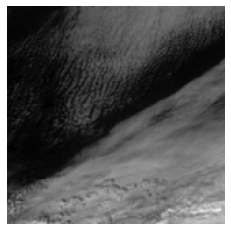

In [8]:
if __name__ == "__main__":
    main()